# Sentiment analysis media cloud extrated data

This notebook implements a foundational Sentiment Analysis pipeline on news titles, addressing the constraint of no labeled training data. We use the VADER lexicon method for classification and demonstrate feature engineering using TF-IDF and Truncated SVD (LSA) for future-proofing and exploration.

In [2]:
# Core Libraries
import pandas as pd
import re

# Sentiment Analysis (Lexicon)
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Feature Extraction and Dimensionality Reduction (ML components)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# vizualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:

# --- Sample Newspaper Titles Data ---
media_cloud = pd.read_csv("../data/mediacloud-PO-translation.csv") 
media_cloud.head()

,id,indexed_date,language,media_name,media_url,publish_date,title,url,translated_title,political_orientation
0,1dc171e7750c319dc4a7b4ca87c8a6f5587c0e9481f129...,2025-11-03 00:22:19.404264+00:00,en,techcrunch.com,techcrunch.com,2025-11-02,Google pulls Gemma from AI Studio after Senato...,https://techcrunch.com/2025/11/02/google-pulls...,Google pulls Gemma from AI Studio after Senato...,center
1,e6a47f0c7b6de768d799e603b5797ca432f9af6903de7b...,2025-11-02 23:17:22.553191+00:00,en,livemint.com,livemint.com,2025-11-02,Here's why India’s AI content draft rules miss...,https://www.livemint.com/opinion/online-views/...,Here's why India’s AI content draft rules miss...,center
2,8061d40a29f0fcf33e6906573a72389a4c0a0cc136522c...,2025-11-02 21:51:34.827292+00:00,en,apnews.com,apnews.com,2025-11-02,Who is Zico Kolter? A professor leads OpenAI s...,https://apnews.com/article/openai-safety-chatg...,Who is Zico Kolter? A professor leads OpenAI s...,center
3,d411e1a49c87e2e710c054d514f58beebcfa2f275107d8...,2025-11-02 20:26:57.088674+00:00,es,infolibre.es,infolibre.es,2025-11-02,"ChatGPT no es un psicólogo, pero cambiará su l...",https://www.infolibre.es/politica/chatgpt-rect...,"ChatGPT is not a psychologist, but it will cha...",center
4,c8ce06691fdf797a875be76c82efb7b0fab0d3d62a795c...,2025-11-02 20:17:51.246694+00:00,en,thestar.com,thestar.com,2025-11-02,"Like maple syrup and hockey, AI must become a ...",https://www.thestar.com/business/opinion/like-...,"Like maple syrup and hockey, AI must become a ...",center


In [4]:
#let's conduct a sanity check on the data
print(media_cloud["language"].value_counts())

language
en    28928
de     1724
es      831
pl      807
it      631
fr      466
ja      368
sv      284
nl      247
ro      209
pt      131
id       84
hr       43
hu       36
fi       36
no       33
tr       30
ru       29
sq       17
ko       16
hi       15
th       14
bg       12
el       11
ca       11
fa        9
tl        8
la        8
uk        7
cs        5
ar        4
gl        3
sr        3
is        3
sw        2
ur        2
mk        2
mt        1
ml        1
ta        1
sk        1
ka        1
az        1
Name: count, dtype: int64


# Preprocessing and Text Cleaning

In [5]:
def clean_text(text):
    # 1. Lowercasing (Standard practice for normalization)
    text = text.lower()
    # 2. Remove text inside parentheses (often non-essential context in titles)
    text = re.sub(r'\([^)]*\)', '', text)
    # 3. Remove most punctuation, but KEEP VADER-relevant symbols (like ! and ?)
    # VADER is explicitly designed to use punctuation (!!!) and capitalization (ALL CAPS)
    # as intensifiers. We will clean for the *TF-IDF* features but keep the raw
    # title for VADER, which is why we create a separate 'Clean_Title' column.
    return text

# We will create a clean version for feature extraction (TF-IDF)
media_cloud['clean_title'] = media_cloud['title'].apply(clean_text)


# Core Sentiment Classification (Lexicon-Based)

In [6]:
analyzer = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    # Use the ORIGINAL 'Title' for VADER to leverage capitalization and punctuation
    return analyzer.polarity_scores(text)['compound']

def classify_sentiment(score):
    # Standard VADER thresholds
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

media_cloud['VADER_Compound_Score'] = media_cloud['title'].apply(get_vader_sentiment)
media_cloud['Sentiment_VADER'] = media_cloud['VADER_Compound_Score'].apply(classify_sentiment)

print("--- Sentiment Analysis Results (VADER) ---")
print(media_cloud[['title', 'VADER_Compound_Score', 'Sentiment_VADER']])

--- Sentiment Analysis Results (VADER) ---
                                                   title  \
0      Google pulls Gemma from AI Studio after Senato...   
1      Here's why India’s AI content draft rules miss...   
2      Who is Zico Kolter? A professor leads OpenAI s...   
3      ChatGPT no es un psicólogo, pero cambiará su l...   
4      Like maple syrup and hockey, AI must become a ...   
...                                                  ...   
35070  New Delhi Slush’D witnessed unprecedented succ...   
35071                           AI on human rights watch   
35072  Con su propia criptomoneda, el creador del Cha...   
35073  Musk ‘sensationalist’ comments on AI taking jo...   
35074  Угроза катастрофического уровня: США и Китай п...   

       VADER_Compound_Score Sentiment_VADER  
0                   -0.3400        Negative  
1                   -0.1531        Negative  
2                    0.4215        Positive  
3                   -0.2960        Negative  
4     

# Post-Classification Exploration and Feature Engineering

In [7]:
# Vectorize the CLEANED text
vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
tfidf_matrix = vectorizer.fit_transform(media_cloud['clean_title'])
feature_names = vectorizer.get_feature_names_out()

print("TF-IDF Vectorization Complete.")
print(f"Shape of TF-IDF Matrix (Rows: Titles, Columns: Features): {tfidf_matrix.shape}")

TF-IDF Vectorization Complete.
Shape of TF-IDF Matrix (Rows: Titles, Columns: Features): (35075, 174908)


In [8]:
# Reduce dimensions to 2 components for ease of inspection
svd = TruncatedSVD(n_components=2, random_state=42)
lsa_result = svd.fit_transform(tfidf_matrix)

media_cloud['LSA_Component_1'] = lsa_result[:, 0]
media_cloud['LSA_Component_2'] = lsa_result[:, 1]

print("\n--- Exploration: LSA Components and Sentiment ---")
print(media_cloud[['Sentiment_VADER', 'LSA_Component_1', 'LSA_Component_2']])

# Look at the top features that define the discovered LSA components (the 'topics')
print("\nTop features defining the LSA Components (Inferred Topics):")
for i, comp in enumerate(svd.components_):
    # Get the top 5 words/n-grams that contribute most to this component
    sorted_idx = comp.argsort()[::-1][:5]
    top_words = [feature_names[j] for j in sorted_idx]
    print(f"Component {i+1}: {top_words}")


--- Exploration: LSA Components and Sentiment ---
      Sentiment_VADER  LSA_Component_1  LSA_Component_2
0            Negative         0.034103    -1.333086e-02
1            Negative         0.058994    -1.751540e-02
2            Positive         0.067387    -3.050457e-02
3            Negative         0.007667     4.875266e-04
4            Positive         0.036217    -1.446942e-02
...               ...              ...              ...
35070        Positive         0.018160    -3.828720e-03
35071         Neutral         0.067149    -1.961416e-02
35072         Neutral         0.010104     7.405663e-03
35073         Neutral         0.055345    -2.022868e-02
35074         Neutral         0.000002    -8.968234e-07

[35075 rows x 3 columns]

Top features defining the LSA Components (Inferred Topics):
Component 1: ['ai', 'intelligence', 'safety', 'artificial', 'artificial intelligence']
Component 2: ['intelligence', 'artificial', 'artificial intelligence', 'artificielle', 'intelligence ar

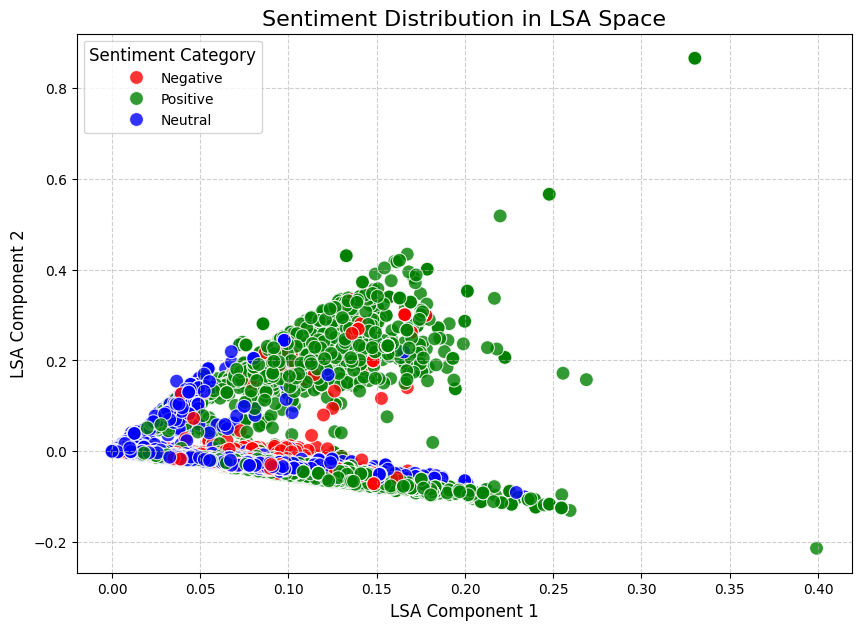

In [9]:
# 3. Visualization of LSA Components by Sentiment
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='LSA_Component_1',
    y='LSA_Component_2',
    hue='Sentiment_VADER',  # Color points by sentiment
    data=media_cloud,
    s=100, # Size of points
    alpha=0.8, # Transparency
    palette={'Positive': 'green', 'Negative': 'red', 'Neutral': 'blue'} # Custom colors
)

# Add titles for clarity
plt.title('Sentiment Distribution in LSA Space', fontsize=16)
plt.xlabel('LSA Component 1', fontsize=12)
plt.ylabel('LSA Component 2', fontsize=12)

# Ensure the legend is displayed clearly
plt.legend(title='Sentiment Category', title_fontsize='12', fontsize='10')

plt.grid(True, linestyle='--', alpha=0.6)


plt.show()

In [10]:
# Create a DataFrame from the TF-IDF matrix
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
tfidf_df['Sentiment_VADER'] = media_cloud['Sentiment_VADER'].values

# Group by sentiment and compute mean TF-IDF scores
grouped_tfidf = tfidf_df.groupby('Sentiment_VADER').mean()

In [11]:
for sentiment in grouped_tfidf.index:
    top_words = grouped_tfidf.loc[sentiment].sort_values(ascending=False).head(10)
    print(f"\nTop TF-IDF words for {sentiment} sentiment:")
    print(top_words)



Top TF-IDF words for Negative sentiment:
ai         0.031400
risks      0.009201
openai     0.008828
risk       0.007947
warns      0.007899
eu         0.007225
tech       0.007024
die        0.006540
chatgpt    0.006218
musk       0.005894
Name: Negative, dtype: float64

Top TF-IDF words for Neutral sentiment:
ai            0.025969
la            0.008118
eu            0.007601
ki            0.006624
openai        0.006550
tech          0.006382
new           0.005966
regulation    0.005370
chatgpt       0.005323
musk          0.004870
Name: Neutral, dtype: float64

Top TF-IDF words for Positive sentiment:
ai                         0.034351
intelligence               0.018558
safety                     0.018275
artificial intelligence    0.016065
artificial                 0.015397
ai safety                  0.014018
tech                       0.008026
summit                     0.007531
new                        0.007414
uk                         0.006527
Name: Positive, dtype: f

# Let's see how this results change according to each year

we first create different datasets where the filter is the year

and we do the same analysis done above

In [12]:
media_cloud['publish_date'] = pd.to_datetime(media_cloud.get('publish_date', media_cloud.get('date', None)), errors='coerce')
media_cloud['year'] = media_cloud['publish_date'].dt.year


/var/folders/s7/06176ck52670b55rv_lly5980000gn/T/ipykernel_33266/3980610014.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment_VADER', data=yearly_data, order=['Positive', 'Neutral', 'Negative'],


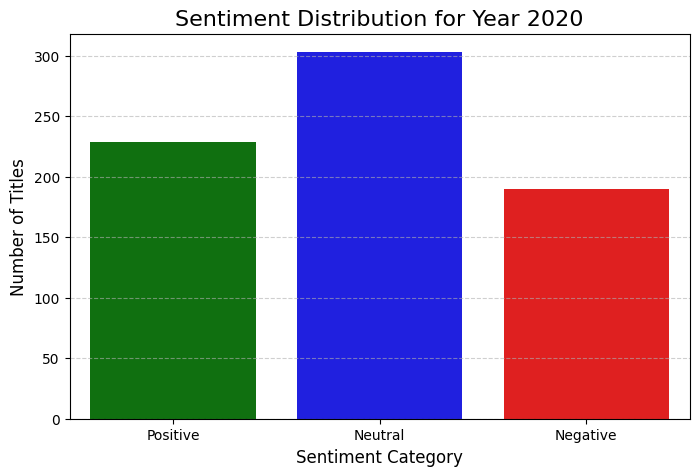


Year 2020 - Top TF-IDF words for Negative sentiment:
trump                0.031226
coronavirus          0.025914
facebook             0.022329
rules hate           0.017017
eu threatens         0.017017
tougher rules        0.016865
hate speech          0.016725
rules                0.016295
threatens tougher    0.015807
facebook meeting     0.015647
Name: Negative, dtype: float64

Year 2020 - Top TF-IDF words for Neutral sentiment:
trump                0.018949
ai                   0.018357
democratic           0.015638
democratic debate    0.015388
google               0.014535
debate               0.014133
watch                0.014120
regulation           0.013925
ai regulation        0.012502
impeachment          0.011164
Name: Neutral, dtype: float64

Year 2020 - Top TF-IDF words for Positive sentiment:
artificial intelligence    0.028439
intelligence               0.027658
artificial                 0.027079
ai                         0.021255
2020                       0.01241

/var/folders/s7/06176ck52670b55rv_lly5980000gn/T/ipykernel_33266/3980610014.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment_VADER', data=yearly_data, order=['Positive', 'Neutral', 'Negative'],


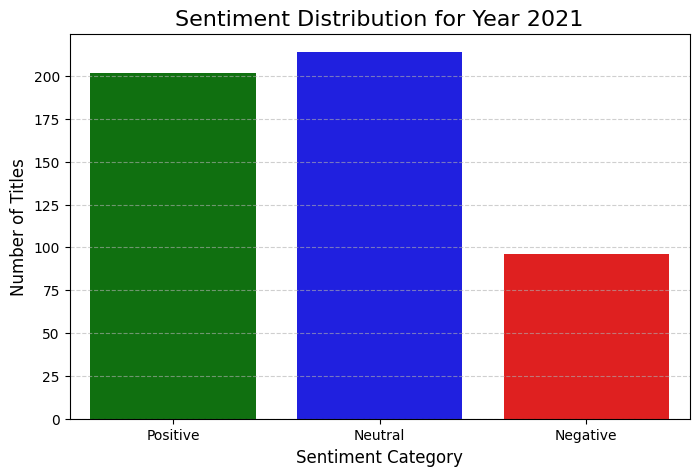


Year 2021 - Top TF-IDF words for Negative sentiment:
ban              0.031402
eu               0.029764
rules            0.027171
ai               0.026741
brother fears    0.023352
ai rules         0.022697
big brother      0.022560
brother          0.022560
rules ban        0.021270
temper big       0.020531
Name: Negative, dtype: float64

Year 2021 - Top TF-IDF words for Neutral sentiment:
ai                 0.023569
tech               0.013201
strategy           0.012181
national           0.011684
eu                 0.011239
synthetic media    0.011189
ai synthetic       0.011189
enters perilous    0.011062
perilous phase     0.011062
tech enters        0.011062
Name: Neutral, dtype: float64

Year 2021 - Top TF-IDF words for Positive sentiment:
ai                         0.028055
artificial intelligence    0.023965
intelligence               0.023400
artificial                 0.022392
2021                       0.017941
panel urges                0.017315
skills amid           

/var/folders/s7/06176ck52670b55rv_lly5980000gn/T/ipykernel_33266/3980610014.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment_VADER', data=yearly_data, order=['Positive', 'Neutral', 'Negative'],


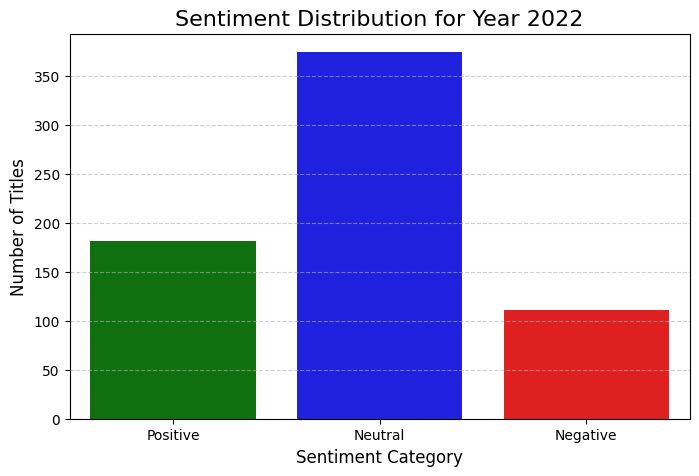

/var/folders/s7/06176ck52670b55rv_lly5980000gn/T/ipykernel_33266/3980610014.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment_VADER', data=yearly_data, order=['Positive', 'Neutral', 'Negative'],



Year 2022 - Top TF-IDF words for Negative sentiment:
ai           0.033471
ai ethics    0.019167
ethics       0.017257
eu           0.016893
collapse     0.013568
liable ai    0.013263
liable       0.012969
die          0.011380
looming      0.011065
crypto       0.010725
Name: Negative, dtype: float64

Year 2022 - Top TF-IDF words for Neutral sentiment:
ai                 0.020880
la                 0.015916
ai rises           0.014588
lawmakers try      0.014284
try catch          0.014284
rises lawmakers    0.014194
peine              0.013982
rises              0.013672
la peine           0.013303
peine pour         0.013303
Name: Neutral, dtype: float64

Year 2022 - Top TF-IDF words for Positive sentiment:
ai                         0.033232
intelligence               0.029086
artificial intelligence    0.026300
artificial                 0.024573
ai ethics                  0.014691
ethics                     0.014415
data                       0.012024
ethics ai                 

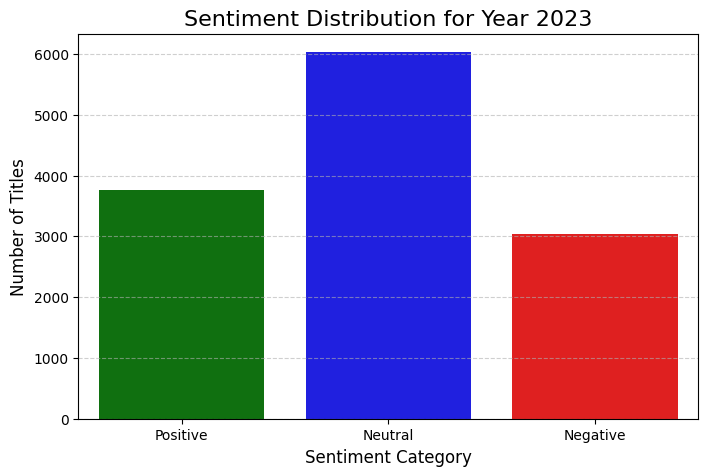


Year 2023 - Top TF-IDF words for Negative sentiment:
ai            0.032247
risks         0.012406
risk          0.011792
openai        0.011759
warns         0.011703
chatgpt       0.010968
extinction    0.010183
experts       0.008131
eu            0.008074
altman        0.008053
Name: Negative, dtype: float64

Year 2023 - Top TF-IDF words for Neutral sentiment:
ai            0.026256
chatgpt       0.009980
openai        0.009929
musk          0.009537
eu            0.008901
la            0.008631
regulation    0.007169
elon          0.006862
elon musk     0.006826
tech          0.006576
Name: Neutral, dtype: float64

Year 2023 - Top TF-IDF words for Positive sentiment:
ai                         0.034683
intelligence               0.025059
artificial intelligence    0.022155
artificial                 0.021035
safety                     0.020159
ai safety                  0.016936
summit                     0.013175
uk                         0.010785
world                      0.0

/var/folders/s7/06176ck52670b55rv_lly5980000gn/T/ipykernel_33266/3980610014.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment_VADER', data=yearly_data, order=['Positive', 'Neutral', 'Negative'],


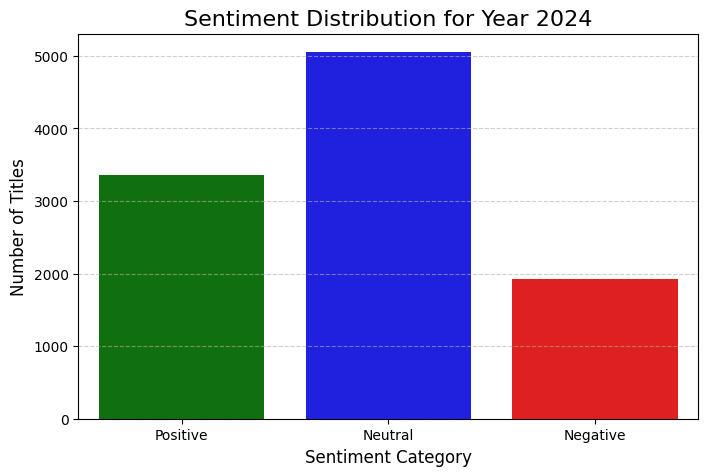


Year 2024 - Top TF-IDF words for Negative sentiment:
ai          0.029845
openai      0.009802
risks       0.009263
election    0.007001
risk        0.006569
tech        0.006569
musk        0.006474
says        0.006432
die         0.006000
ai risks    0.005974
Name: Negative, dtype: float64

Year 2024 - Top TF-IDF words for Neutral sentiment:
ai        0.024703
2024      0.011955
ki        0.008050
eu        0.007511
la        0.006746
tech      0.006217
openai    0.006155
act       0.005859
new       0.005526
ai act    0.005335
Name: Neutral, dtype: float64

Year 2024 - Top TF-IDF words for Positive sentiment:
ai                         0.035257
safety                     0.023899
ai safety                  0.017786
intelligence               0.016603
artificial intelligence    0.013997
artificial                 0.013461
new                        0.009888
openai                     0.008762
tech                       0.007586
california                 0.007311
Name: Positive, dt

/var/folders/s7/06176ck52670b55rv_lly5980000gn/T/ipykernel_33266/3980610014.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment_VADER', data=yearly_data, order=['Positive', 'Neutral', 'Negative'],


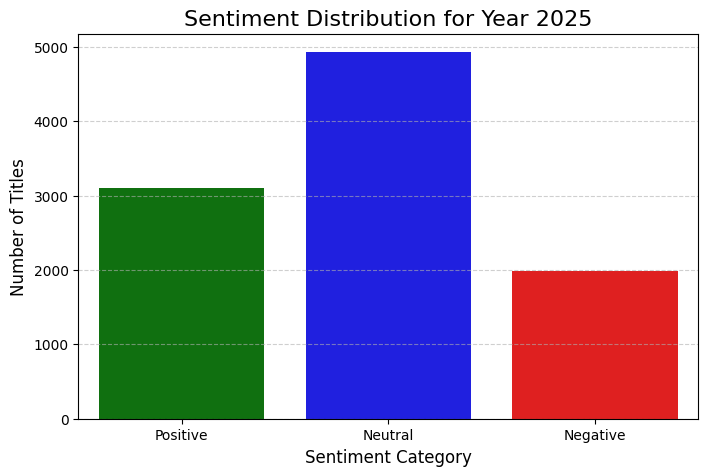


Year 2025 - Top TF-IDF words for Negative sentiment:
ai            0.033756
trump         0.012885
ban           0.010974
die           0.009455
tech          0.007096
senate        0.006770
warns         0.006297
new           0.006262
regulation    0.006167
state         0.005931
Name: Negative, dtype: float64

Year 2025 - Top TF-IDF words for Neutral sentiment:
ai        0.027874
la        0.008577
2025      0.008551
trump     0.008460
ki        0.006780
new       0.006573
tech      0.006191
eu        0.006029
ia        0.005042
policy    0.004558
Name: Neutral, dtype: float64

Year 2025 - Top TF-IDF words for Positive sentiment:
ai                         0.034410
safety                     0.012480
intelligence               0.011178
innovation                 0.009208
artificial intelligence    0.008885
ai safety                  0.008797
artificial                 0.008794
trump                      0.008728
new                        0.007077
global                     0.00657

In [13]:
# ...existing code...
import numpy as np

for year in sorted(media_cloud['year'].dropna().unique()):
    yearly_data = media_cloud[media_cloud['year'] == year]
    if yearly_data.empty:
        continue

    # distribution plot
    plt.figure(figsize=(8, 5))
    sns.countplot(x='Sentiment_VADER', data=yearly_data, order=['Positive', 'Neutral', 'Negative'],
                  palette={'Positive': 'green', 'Negative': 'red', 'Neutral': 'blue'})
    plt.title(f'Sentiment Distribution for Year {year}', fontsize=16)
    plt.xlabel('Sentiment Category', fontsize=12)
    plt.ylabel('Number of Titles', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()

    # transform YEARLY cleaned titles (do NOT refit vectorizer)
    yearly_tfidf = vectorizer.transform(yearly_data['clean_title'])  # sparse matrix (n_titles x n_features)

    # compute mean TF-IDF per sentiment (sparse-safe)
    if yearly_tfidf.shape[0] <= 5000:
        tfidf_df = pd.DataFrame(yearly_tfidf.toarray(), columns=feature_names, index=yearly_data.index)
        tfidf_df['Sentiment_VADER'] = yearly_data['Sentiment_VADER'].values
        grouped_tfidf = tfidf_df.groupby('Sentiment_VADER').mean()
    else:
        grouped = {}
        # .groups returns mapping sentiment -> list of index labels in yearly_data
        for sentiment, idx_labels in yearly_data.groupby('Sentiment_VADER').groups.items():
            pos = yearly_data.index.get_indexer(list(idx_labels))  # positions relative to yearly_tfidf rows
            sub = yearly_tfidf[pos]
            mean_vec = sub.mean(axis=0)
            grouped[sentiment] = pd.Series(np.asarray(mean_vec).ravel(), index=feature_names)
        grouped_tfidf = pd.DataFrame(grouped).T

    # print top words per sentiment for this year
    for sentiment in grouped_tfidf.index:
        top_words = grouped_tfidf.loc[sentiment].sort_values(ascending=False).head(10)
        print(f"\nYear {year} - Top TF-IDF words for {sentiment} sentiment:")
        print(top_words)
# ...existing code...

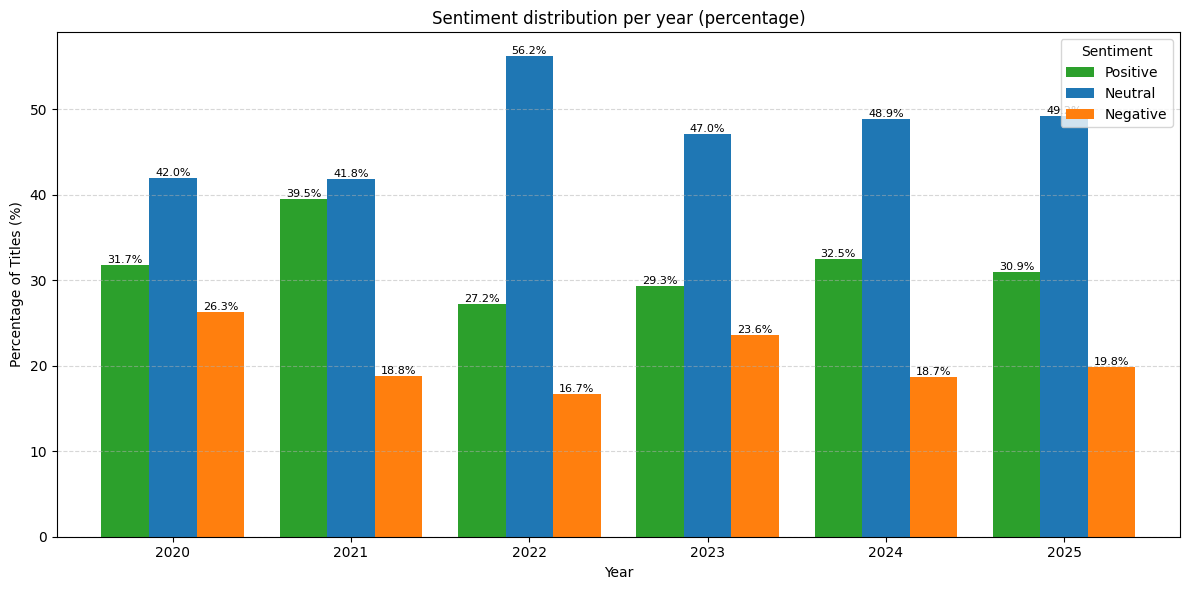

In [14]:
import numpy as np

# ensure desired sentiment order
sentiments_order = ['Positive', 'Neutral', 'Negative']

# compute counts per year x sentiment and convert to percentages per year
counts = media_cloud.groupby(['year', 'Sentiment_VADER']).size().unstack(fill_value=0)
counts = counts.reindex(columns=sentiments_order, fill_value=0)  # enforce column order
counts_pct = counts.div(counts.sum(axis=1), axis=0) * 100  # percent per year

# plot grouped bars (each year has three bars: Positive, Neutral, Negative)
ax = counts_pct.plot(kind='bar', figsize=(12, 6), width=0.8, color=[ '#2ca02c', '#1f77b4' , '#ff7f0e'] )
ax.set_ylabel('Percentage of Titles (%)')
ax.set_xlabel('Year')
ax.set_title('Sentiment distribution per year (percentage)')
ax.legend(title='Sentiment', loc='upper right')
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=0)

# annotate bars with percentage values
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2, height),
                    ha='center', va='bottom', fontsize=8, rotation=0)

plt.tight_layout()
plt.show()


In [15]:
# let's save the updated DataFrame into a new CSV file
media_cloud.to_csv("../data/mediacloud-sentiment-analysis.csv", index=False)

# analysis of sentiment across outlets of the same political leaning

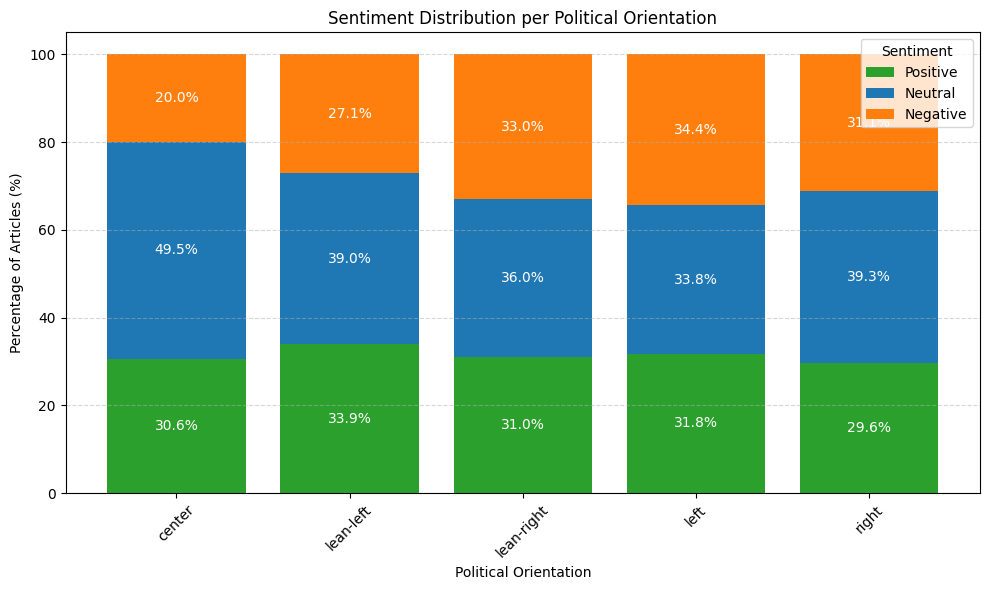

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Prepare  calculate sentiment counts per political_orientation
count_df = media_cloud.groupby(['political_orientation', 'Sentiment_VADER']).size().unstack(fill_value=0)

# Calculate percentages per political orientation
perc_df = count_df.div(count_df.sum(axis=1), axis=0) * 100

# Define colors for sentiments
colors = {'Positive': '#2ca02c', 'Neutral': '#1f77b4', 'Negative': '#ff7f0e'}

fig, ax = plt.subplots(figsize=(10, 6))

bottom = np.zeros(len(perc_df))
orientations = perc_df.index

# Plot stacked bars
for sentiment in ['Positive', 'Neutral', 'Negative']:
    values = perc_df[sentiment].values
    bars = ax.bar(orientations, values, bottom=bottom, color=colors[sentiment], label=sentiment)
    
    # Annotate with percentage inside each segment
    for bar, pct in zip(bars, values):
        if pct > 5:  # annotate only if segment visible enough
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2,
                    f'{pct:.1f}%', ha='center', va='center', color='white', fontsize=10)
    
    bottom += values

ax.set_ylabel('Percentage of Articles (%)')
ax.set_xlabel('Political Orientation')
ax.set_title('Sentiment Distribution per Political Orientation')
ax.legend(title='Sentiment')
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
